In [1]:
import sys
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import copy
sys.path.insert(0, '/home/ryan/projects/CHARM-KASTr/py/')
from median import median
from create_mask import create_mask
from normalize_flat import normalize_flat
from bias_subtract import bias_subtract
from variance_image import variance_image

In [2]:
run floader.py

In [3]:
b = median(BIAS)

f = median(FLAT)

m = create_mask(f,b)

nf = normalize_flat(f,m)

subtr = bias_subtract(f, b)

In [4]:
ghdul = fits.open('/home/ryan/projects/CHARMKASTR/raw/data-2017-08-12-shane-Adam.Burgasser/red/test1035/science/r1033.fits')

g_star = ghdul[0].data

In [5]:
g_subtr = bias_subtract(g_star, b)

g_var = variance_image(g_subtr)

g_norm = g_subtr / nf


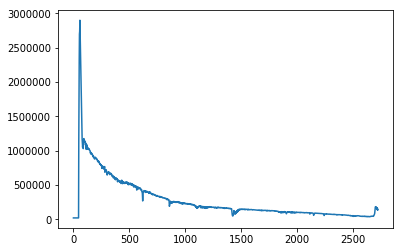

In [26]:
testg_norm = copy.deepcopy(g_norm)

for i in range(len(testg_norm)):
    testg_norm[i] = testg_norm[i] / np.amax(nf[i])


testg_masked = copy.deepcopy(testg_norm)
testg_median = np.median(testg_norm)

for i in range (testg_masked.shape[0]):
    for j in range(testg_masked.shape[1]):
        if m[i][j] == 1:
            testg_masked[i][j] = testg_median
            
plt.plot(np.sum(testg_masked, axis=1))

In [7]:
g_median = np.median(g_norm)

In [8]:
g_masked = copy.deepcopy(g_norm)

for i in range (g_masked.shape[0]):
    for j in range(g_masked.shape[1]):
        if m[i][j] == 1:
            g_masked[i][j] = g_median
            

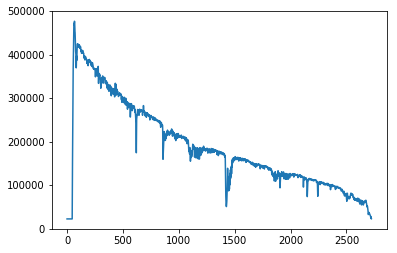

In [9]:
plt.plot(np.sum(g_masked, axis=1))

In [10]:
xpk = np.argmax(g_masked, axis=1)

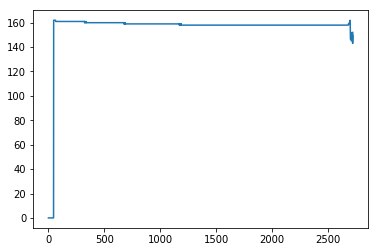

In [11]:
plt.plot(xpk)

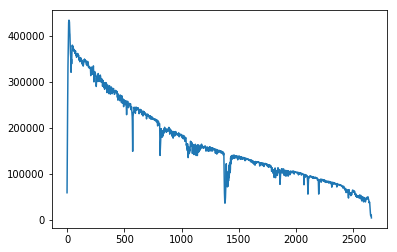

In [12]:
xpeak = []
impc = []
for i in range(len(g_masked[:,0])):
    slc = g_masked[i,:]
    xpeak.append(np.argmax(slc))
    if xpeak[-1] > 150 and xpeak[-1] < 165:
        impc.append(slc[xpeak[-1]-10:xpeak[-1]+10])
plt.plot(np.sum(impc,axis=1))

In [13]:
yrange = np.arange(0, xpk.size, 1)

fitxpk = copy.deepcopy(xpk)

xpkmedian = np.median(xpk)

'''
How to deal with outliers (identification and masking)?

Currently, just looking at the plot of x vs y and seeing a suitable range
if outside that range, masking by replacing with the median value.
'''

for i in range(xpk.size):
    if xpk[i] <= 155 or xpk[i] >= 165:
        fitxpk[i] = xpkmedian

'''
Fitting:
How to determine whether a 3rd order or 4th order fit is better?
Is there a higher order equivalent of an R^2?
'''
p = np.poly1d(np.polyfit(yrange, fitxpk, 3))

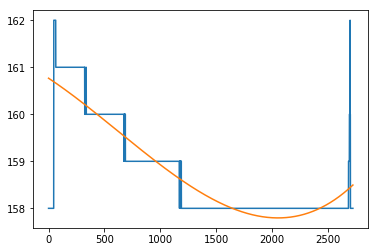

In [14]:
plt.plot(fitxpk)
plt.plot(yrange, p(yrange))

In [15]:
islc = []
for i in range(len(g_masked[:, 0])):
    slc = g_masked[i,:]
    islc.append(slc[int(p(i)-10):int(p(i)+10)])

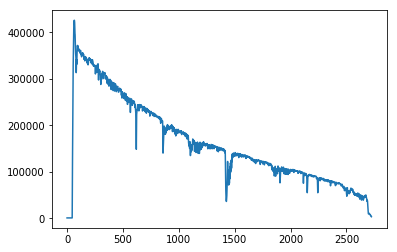

In [16]:
plt.plot(np.sum(islc, axis=1))

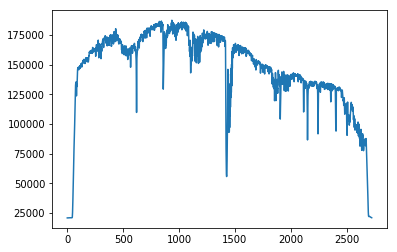

In [17]:
testslc = []
for i in range(len(g_star[:, 0])):
    slc = g_star[i,:]
    testslc.append(slc[int(p(i)-10):int(p(i)+10)])
    
plt.plot(np.sum(testslc, axis=1))

In [18]:
fslc = []
tslc = copy.deepcopy(islc)
for i in range(len(islc)):
    slc = tslc[i]
    smax = np.amax(slc)
    smedian = np.median(slc)
        
    slc = slc - smedian
    slc = slc / smax
    
    fslc.append(slc)


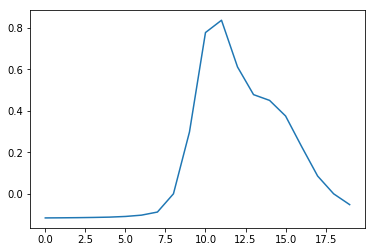

In [19]:
#median along which axis for the weighting function?

plt.plot(np.median(fslc, axis=0))



In [20]:
wfunc = np.median(fslc, axis=0)


In [21]:
flx = []
xslc = copy.deepcopy(islc)

for i in range(len(xslc)):
    for j in range(len(xslc[i])):
        if wfunc[j] < 0.1:
            xslc[i][j] = xslc[i][j] - np.median(xslc[i])
            
        xslc[i][j] = xslc[i][j] * wfunc[j]
        
    flx.append(np.sum(xslc[i]) / np.sum(wfunc)) 
        

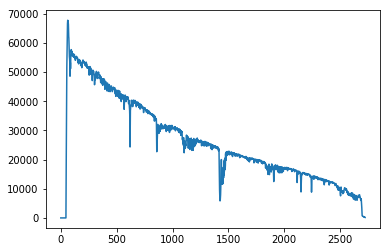

In [22]:
plt.plot(flx)

In [27]:
testslc = []
for i in range(len(testg_masked[:, 0])):
    slc = g_subtr[i,:]
    testslc.append(slc[int(p(i)-10):int(p(i)+10)])


testw = []

for i in range(len(testslc)):
    slc = testslc[i]
    smax = np.amax(slc)
    smedian = np.median(slc)
        
    slc = slc - smedian
    slc = slc / smax
    
    testw.append(slc)

testwfunc = np.median(testw, axis=0)

testflx = []

for i in range(len(testslc)):
    for j in range(len(testslc[i])):
        if testwfunc[j] < 0.1:
            testslc[i][j] = testslc[i][j] - np.median(testslc[i])
            
        testslc[i][j] = testslc[i][j] * testwfunc[j]
        
    testflx.append(np.sum(testslc[i]) / np.sum(testwfunc)) 

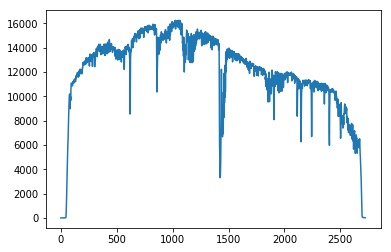

In [28]:
plt.plot(testflx)